# Stochastic Signal Detection (SSD)

In what follows, we prepare the pictures for the study of the Stochastic Signal Detection (SSD).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

plt.style.use('ggplot')
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

from ssd.distributions import MarchenkoPastur

## The Marchenko-Pastur Law

The MP law $\mu(\Lambda)$ is the **asymptotic behaviour** of the **singular values** of a **large rectangular matrix**.
That is, the distribution of the **eigenvalues** of the corresponding **covariance matrix**.

Let $X \in \mathbb{R}^{n \times p}$ be a rectangular Wishart matrix, with $n \to \infty$ and $p \to \infty$, such that $\frac{p}{n} \to \xi \in (0, +\infty)$.
Define $\lambda_i$, with $i = 1, 2, \dots, n$, its eigenvalues. Then,
$$
\tilde{\mu}(\Lambda)
=
\frac{1}{n} \#
\left\lbrace
    \lambda_i \in A \subset \mathbb{R}
\right\rbrace
\to
\mu(\Lambda)
=
\begin{cases}
\nu(\Lambda) &~\text{if}~ \xi < 1
\\
(1 - \frac{1}{\xi} \mathbb{I}_{0 \in \Lambda}) + \nu{\Lambda} &~\text{if}~ \xi \ge 1
\end{cases},
$$
where:
$$
\mathrm{d}\nu(\lambda)
=
\frac{1}{2 \pi \sigma^2}
\frac{\sqrt{(\xi_+ - \lambda)(\lambda - \xi_-)}}{\xi \lambda} \mathrm{d}x,
$$
with $\xi_{\pm} = \sigma^2 (1 \pm \sqrt{\xi})^2$.

In [3]:
# Define the parameters of the distribution
xi = 0.4
sigma = 1.0

# Create random matrices
n_list = [100, 400, 5000]
p_list = [int(xi * n) for n in n_list]
X_list = []
E_list = []
for n, p in zip(n_list, p_list):
    X_list.append(np.random.normal(0, sigma, (n, p)))  # matrix
    E_list.append(np.linalg.eigvalsh(X_list[-1].T @ X_list[-1]
                                     / n))  # eigenvalues


In [4]:
# Define the MP law
mp = MarchenkoPastur(xi, sigma)

# Define the bounds of the support
m = 0
M = max([max(e) for e in E_list]) * 1.1

# Compute the values of the MP law
x = np.linspace(m, M, 1000)
y = np.array([mp(e) for e in x])

In what follows, we show the convergence of the empirical distribution towards the MP law, as the size of the matrix increases.

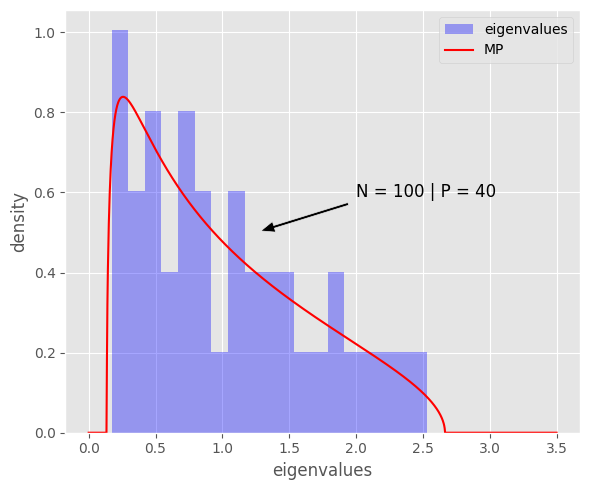

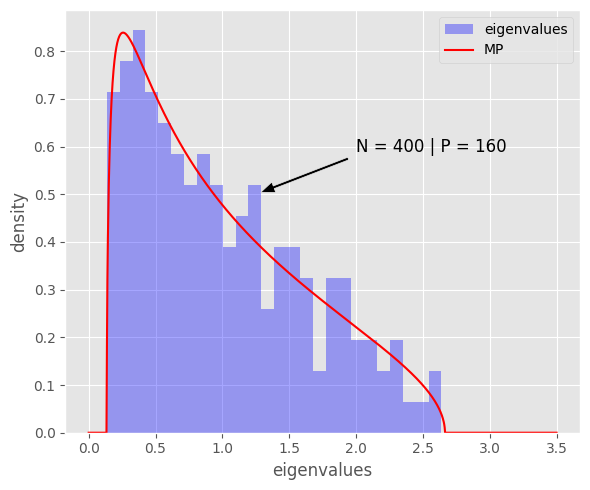

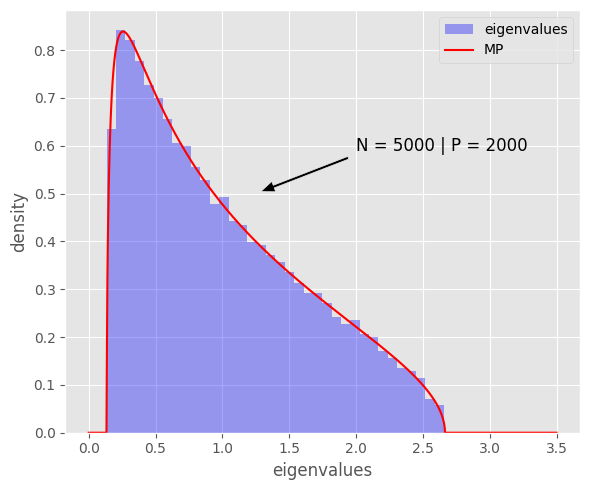

In [8]:
# Plot the eigenvalues of the sample covariance matrix and the MP distribution
for n, e in enumerate(E_list):

    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot the eigenvalues
    bins = int(np.ceil((max(e) - min(e)) * np.ceil(np.log2(n_list[n]) + 1)))
    ax.hist(E_list[n],
            bins=bins,
            density=True,
            color='b',
            alpha=0.35,
            label='eigenvalues')

    # Plot the Marchenko-Pastur distribution
    ax.plot(x, y, 'r-', label='MP')

    # Set the labels
    ax.legend(loc='best')
    ax.set_xlabel('eigenvalues')
    ax.set_ylabel('density')
    ax.annotate(f'N = {n_list[n]} | P = {p_list[n]}',
                xy=(1.25, 0.5),
                xytext=(2.0, 0.6),
                fontsize=12,
                arrowprops={
                    'facecolor': 'black',
                    'shrink': 0.05,
                    'width': 2.0,
                    'headwidth': 8.0,
                    'headlength': 10.0
                },
                va='center')

    fig.tight_layout()
    fig.savefig(output_dir / f'mp_histogram_n={n_list[n]}_p={p_list[n]}.pdf',
                dpi=300)
    plt.show(block=False)
    plt.close(fig)

## Signal Detection

We are interested in studying **small deformations** from the MP law for signal detection.
The difference with _localized spikes_ is the inherent impossible distinction between **signal** and **bulk**, as no hard thresholding can be performed.

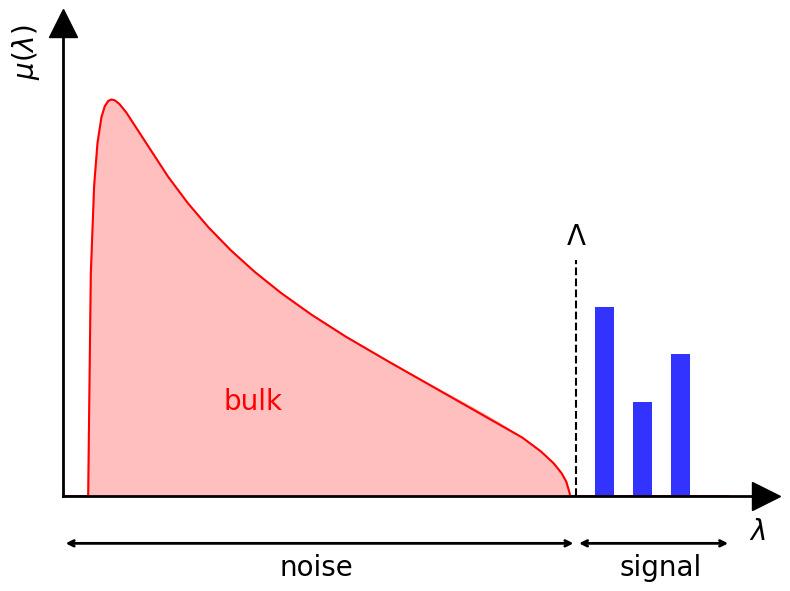

In [6]:
# Plot the case of localized spikes
x = np.linspace(0, 3.5, 1000)
y = np.array([mp(e) for e in x])

counts = np.array([0, 0.4, 0, 0.2, 0, 0.3])
bins = np.array([2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3])

with plt.style.context('fast', after_reset=True):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the data
    ax.plot(x, y, 'r-', label='MP')
    ax.hist(bins[:-1],
            bins=bins,
            weights=counts,
            color='b',
            label='spikes',
            alpha=0.8)

    ax.vlines([2.7], [0], [0.5], ['k'], ['--'])
    ax.text(2.7,
            0.55,
            r'$\Lambda$',
            color='k',
            fontsize=20,
            ha='center',
            va='center')

    ax.annotate('',
                xy=(0, -0.1),
                xytext=(0.73, -0.1),
                xycoords='axes fraction',
                arrowprops={
                    'arrowstyle': '<->', 'color': 'k', 'linewidth': 2
                })
    ax.annotate('',
                xy=(0.73, -0.1),
                xytext=(0.95, -0.1),
                xycoords='axes fraction',
                arrowprops={
                    'arrowstyle': '<->', 'color': 'k', 'linewidth': 2
                })

    ax.annotate('noise',
                xy=(0.36, -0.15),
                xytext=(0.36, -0.15),
                xycoords='axes fraction',
                fontsize=20,
                ha='center',
                va='center')
    ax.annotate('signal',
                xy=(0.85, -0.15),
                xytext=(0.85, -0.15),
                xycoords='axes fraction',
                fontsize=20,
                ha='center',
                va='center')

    # Style the plot
    ax.fill_between(x, 0, y, color='r', alpha=0.25)
    ax.text(1.0, 0.2, 'bulk', color='r', fontsize=20, ha='center', va='center')
    ax.set_xlabel(r'$\lambda$', loc='right', fontsize=20, labelpad=15)
    ax.set_ylabel(r'$\mu(\lambda)$', loc='top', fontsize=20, labelpad=15)

    ax.set_ylim(0, 1.0)
    ax.set_xlim(0, 3.7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.plot(1,
            0,
            ">k",
            transform=ax.get_yaxis_transform(),
            clip_on=False,
            markersize=20)
    ax.plot(0,
            1,
            "^k",
            transform=ax.get_xaxis_transform(),
            clip_on=False,
            markersize=20)

    fig.tight_layout()
    fig.savefig(output_dir / 'spikes.pdf', dpi=300)
    plt.show()
    plt.close(fig)

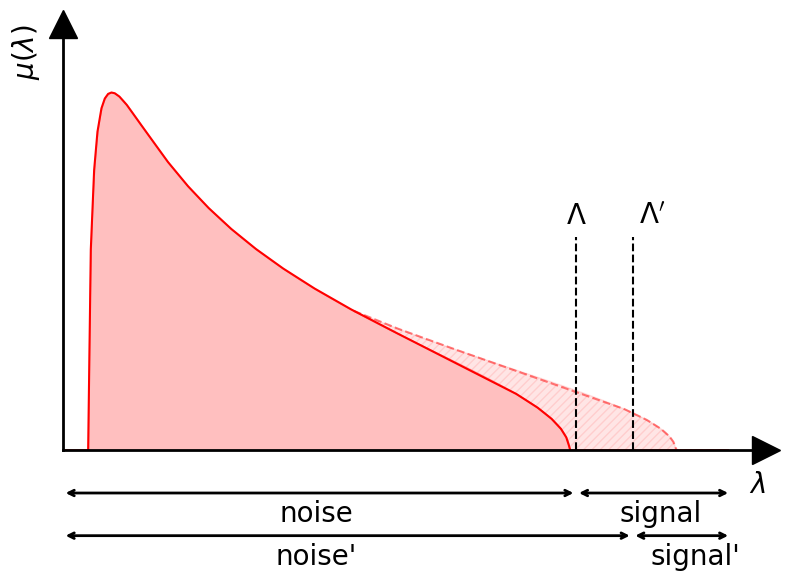

In [7]:
mp2 = MarchenkoPastur(xi, 1.1 * sigma)
yy = np.array([mp2(e) for e in x])

# Find the intersection
idx_1 = np.argwhere(np.diff(np.sign(y - yy))).flatten()

with plt.style.context('fast', after_reset=True):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the data
    ax.plot(x, y, 'r-', label='MP')
    ax.plot(x[idx_1[1]:], yy[idx_1[1]:], 'r--', label='deformation', alpha=0.5)

    ax.vlines([2.7], [0], [0.5], ['k'], ['--'])
    ax.text(2.7,
            0.55,
            r'$\Lambda$',
            color='k',
            fontsize=20,
            ha='center',
            va='center')

    ax.vlines([3.0], [0], [0.5], ['k'], ['--'])
    ax.text(3.1,
            0.55,
            r'$\Lambda^\prime$',
            color='k',
            fontsize=20,
            ha='center',
            va='center')

    ax.annotate('',
                xy=(0, -0.1),
                xytext=(0.73, -0.1),
                xycoords='axes fraction',
                arrowprops={
                    'arrowstyle': '<->', 'color': 'k', 'linewidth': 2
                })
    ax.annotate('',
                xy=(0.73, -0.1),
                xytext=(0.95, -0.1),
                xycoords='axes fraction',
                arrowprops={
                    'arrowstyle': '<->', 'color': 'k', 'linewidth': 2
                })

    ax.annotate('noise',
                xy=(0.36, -0.15),
                xytext=(0.36, -0.15),
                xycoords='axes fraction',
                fontsize=20,
                ha='center',
                va='center')
    ax.annotate('signal',
                xy=(0.85, -0.15),
                xytext=(0.85, -0.15),
                xycoords='axes fraction',
                fontsize=20,
                ha='center',
                va='center')

    ax.annotate('',
                xy=(0, -0.2),
                xytext=(0.81, -0.2),
                xycoords='axes fraction',
                arrowprops={
                    'arrowstyle': '<->', 'color': 'k', 'linewidth': 2
                })
    ax.annotate('',
                xy=(0.81, -0.2),
                xytext=(0.95, -0.2),
                xycoords='axes fraction',
                arrowprops={
                    'arrowstyle': '<->', 'color': 'k', 'linewidth': 2
                })

    ax.annotate('noise\'',
                xy=(0.36, -0.25),
                xytext=(0.36, -0.25),
                xycoords='axes fraction',
                fontsize=20,
                ha='center',
                va='center')
    ax.annotate('signal\'',
                xy=(0.9, -0.25),
                xytext=(0.9, -0.25),
                xycoords='axes fraction',
                fontsize=20,
                ha='center',
                va='center')

    # Style the plot
    ax.fill_between(x, 0, y, color='r', alpha=0.25)
    ax.fill_between(x[idx_1[1]:],
                    y[idx_1[1]:],
                    yy[idx_1[1]:],
                    color='r',
                    alpha=0.1,
                    hatch='////')
    ax.set_xlabel(r'$\lambda$', loc='right', fontsize=20, labelpad=15)
    ax.set_ylabel(r'$\mu(\lambda)$', loc='top', fontsize=20, labelpad=15)

    ax.set_ylim(0, 1.0)
    ax.set_xlim(0, 3.7)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('data', 0))
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.plot(1,
            0,
            ">k",
            transform=ax.get_yaxis_transform(),
            clip_on=False,
            markersize=20)
    ax.plot(0,
            1,
            "^k",
            transform=ax.get_xaxis_transform(),
            clip_on=False,
            markersize=20)

    fig.tight_layout()
    fig.savefig(output_dir / 'contiguous.pdf', dpi=300)
    plt.show()
    plt.close(fig)